In [1]:
import numpy as np
import pagn.constants as ct
import matplotlib.pyplot as plt
import pagn
import argparse
import imf

import NT_disk_Eqns_V1 as jscript
import binary_formation_distribution_V8 as myscript
import binary_formation_distribution_V10 as myscript2

from scipy.interpolate import UnivariateSpline

from os import makedirs
import os

import pandas as pd
import matplotlib.patches as patch

import powerlaw
import random

import Novikov
import Thompson_edited as edit
from scipy.interpolate import interp1d
from pagn.opacities import electron_scattering_opacity
#scontinuing on from disk_profiles.ipynb to generalise to some rate calculations

In [133]:
MBH_power=6
MBH_digit=1
Mbh=MBH_digit * 10**MBH_power * ct.MSun
spin=0.9

alpha=0.1
eps=0.1
le=0.01

Ledd=jscript.Ledd(Mbh, X=0.7)
Mdot_edd = Ledd / (eps*ct.c ** 2)
Mdot = le * Mdot_edd

mdot=Mdot/Mdot_edd

TT='G23'
DT='SG'

if DT=="SG":
    disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

if DT=="NT":
    disk = Novikov.NovikovThorneAGN(Mbh=Mbh, alpha=alpha, mdot=mdot, eps=eps, spin=spin)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

R_g=Mbh * ct.G /(ct.c*ct.c)

Rmax=0.1*jscript.pc * (Mbh/(1e6 * ct.MSun))**(1/2)

mass_sec=np.genfromtxt("BHs_single_Zsun_rapid_nospin.dat",usecols=(0),skip_header=3,unpack=True)
BIMF='Vaccaro'

cluster=[]
cluster_mass=2 * Mbh/ct.MSun

if BIMF=='Tagawa':
#Tagawa et al 2020 BIMF
    cluster_tagawa = imf.make_cluster(cluster_mass, massfunc='salpeter', alpha=2.3, mmin=0.1, mmax=140)
    for mass in cluster_tagawa:
        if mass<20:
            continue
        elif 20<=mass<40:
            mass_bh=mass/4
        elif 40<=mass<=55:
            mass_bh=10
        elif 55<=mass<=120:
            mass_bh=mass/13 + 5.77
        else:
            mass_bh=15
        cluster.append(mass_bh)
    bh_mass_tot=np.sum(cluster)
    print(f'Total bh mass is {bh_mass_tot}')

elif BIMF=='Bartos':
#Bartos et al 2017 BIMF
    bartos_cluster=imf.make_cluster(0.04*cluster_mass, massfunc='salpeter', alpha=2, mmin=5, mmax=50)
    cluster=bartos_cluster
    print(f'Total bh mass is {np.sum(cluster)}')

elif BIMF=='Vaccaro':
#Actually from Iorio et al 2023, but file provided by MP Vaccaro
    mass_tot=0
    while mass_tot<0.04*cluster_mass:
        c = np.random.randint(0, len(mass_sec))
        cluster.append(mass_sec[c])
        mass_tot+=mass_sec[c]
    print(f'Total bh mass is {np.sum(cluster)}')


a=powerlaw.Power_Law(alpha=2.5, xmin=12*R_g, xmax=Rmax/R_g)
    # print(np.max(a.rvs(len(iorio_bhs))))
R=a.generate_random(len(cluster))

cos_i=np.random.uniform(-1.0, 1.0, len(cluster))

d = {"mbh [Msun]": cluster, 'r [Rg]': R/R_g, 'cos_i': cos_i}
df=pd.DataFrame(data=d)

f=interp1d(disk.R, disk.h, kind='linear', fill_value='extrapolate')
h_clust=f(df['r [Rg]'] * R_g)

df["H/R"]=h_clust/(df['r [Rg]'] * R_g)
df['H']=h_clust

mbh=df['mbh [Msun]']*ct.MSun

i=np.arccos(cos_i)
cos_i2=np.cos(i/2)
sin_i2=np.sin(i/2)

print(disk.Mdisk/ct.MSun)

t_orb=2*np.pi*(df['r [Rg]']*R_g)**(2/3) * (ct.G * Mbh)**(-1/2)
t_align= (t_orb * Mbh**2)/(2*mbh*disk.Mdisk) * cos_i2 * (sin_i2**2 + df['H']/(4*df['r [Rg]']*R_g))**2

df['t_align']=t_align

df.to_csv(f'EMRI_Rates/dataframes/{BIMF}/{DT}_{MBH_digit}e{MBH_power}_alpha_{alpha}_eps_{eps}_le_{le}_spin_{spin}.csv')

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=7386 (R=2.37e+05 Rs)
Beginning star formation at index 7386
Mdisk = 83180.73756592847 Msun
Mdisk/Mbh = 0.08318073756592848
Total bh mass is 80000.3859621225
83180.73756592847


In [ ]:

print(df)
# print(t_align_array)

83180.73756592847
      mbh [Msun]     r [Rg]     cos_i       H/R             H   t_align
0      18.589806  62.520850 -0.271741  0.002843  2.624488e+08  0.880908
1      21.223770  29.144483  0.789897  0.002658  1.143803e+08  0.020056
2      10.364891  50.964193 -0.681451  0.002704  2.034852e+08  1.592986
3      16.207775  26.302234  0.561669  0.002693  1.045963e+08  0.099071
4      19.015642  59.066760  0.077495  0.002798  2.440094e+08  0.531118
...          ...        ...       ...       ...           ...       ...
5902   18.681326  17.990626  0.068647  0.002857  7.589599e+07  0.248435
5903   22.306243  13.077817  0.034658  0.002961  5.717495e+07  0.177814
5904   10.021967  12.223515 -0.925090  0.002967  5.354986e+07  0.404231
5905    7.445696  31.288320  0.875652  0.002640  1.219621e+08  0.021676
5906   18.675671  21.203362 -0.882559  0.002784  8.717812e+07  0.374962

[5907 rows x 6 columns]


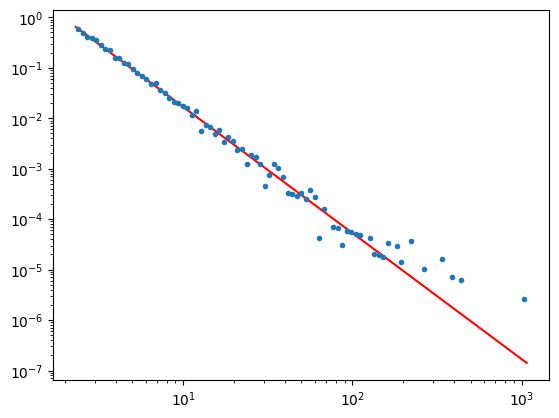

In [15]:
a, xmin, xmax= 2.5, Rmin/R_g, Rmax/R_g
N = len(cluster)

# generates random variates of power law distribution
vrs = powerlaw.Power_Law(xmin=xmin, xmax=xmax, alpha=a).generate_random(len(cluster))

# plotting the PDF estimated from variates
bin_min, bin_max = np.min(vrs), np.max(vrs)
bins = 10**(np.linspace(np.log10(bin_min), np.log10(bin_max), 100))
counts, edges = np.histogram(vrs, bins, density=True)
centers = (edges[1:] + edges[:-1])/2.

# plotting the expected PDF 
xs = np.linspace(bin_min, bin_max, 100000)
plt.plot(xs, [(a-1)*xmin**(a-1)*x**(-a) for x in xs], color='red')
plt.plot(centers, counts, '.')

plt.xscale('log')
plt.yscale('log')


-0.17495871362765913 1.7466601616433723
